In [1]:
import torch
import torch.nn as nn
import math
import joblib

import torch
import torch.nn as nn
from torch.optim import Adam, AdamW, lr_scheduler
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
import matplotlib.pyplot as plt
import joblib
import numpy as np
import random as rd
import soundfile as sf
import pytorch_lightning as pl


In [3]:
def flatten(xss):
    return [x for xs in xss for x in xs]

S = 1
dataset_type = 'maestro'

if dataset_type == 'bach':
    datas = joblib.load("/kaggle/input/holedbach/jsb1-li-train.pkl")
    X = datas['X']
    X = np.array(X)[:, None, 10:90, :]
if dataset_type == 'maestro':
    datas = joblib.load("/kaggle/input/maestrorolls1/Maestro_Rolls1_d2.pkl")
    X = flatten(datas)
    X = np.array(X)[:, None, :, :]
print(X.shape)

"""datas_test = joblib.load("/kaggle/input/musescoremidi2rolls1/MS2_div4_dataset.pkl")
X_test = datas_test['X']
X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1], X_test.shape[2]) # to 1 channel
X_test = X_test[:, :, 10:90, :]"""

from torch.utils.data import DataLoader
X = dataloader = DataLoader(X, batch_size=64, shuffle=True)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

In [4]:
datas = joblib.load("/kaggle/input/maestrorolls1/Maestro_Rolls1_d2.pkl")

In [6]:
S = 1

index = []
for song_idx, song in enumerate(datas):
    for frag_idx in range(len(song)):
        index.append((song_idx, frag_idx))

class FragmentDataset(Dataset):
    def __init__(self, data, index):
        self.data = data
        self.index = index 

    def __len__(self):
        return len(self.index)

    def __getitem__(self, idx):
        song_idx, frag_idx = self.index[idx]
        fragment = self.data[song_idx][frag_idx] 
        fragment = fragment[np.newaxis, :, :] 
        return torch.tensor(fragment, dtype=torch.float32)

dataset = FragmentDataset(datas, index)
val_dataset = FragmentDataset(datas, index[:100])


dataloader = DataLoader(dataset, batch_size=64, shuffle=True, num_workers=2)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


import gc; gc.collect()
del datas

torch.Size([1, 80, 512])


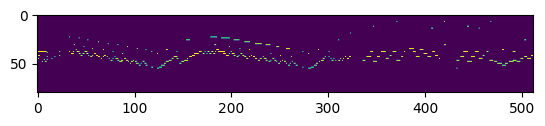

In [7]:
print(dataset[2].shape)
plt.imshow(dataset[2][0])

# Model

In [8]:
class VectorQuantizer(nn.Module):
    """Vector Quantization layer for VQ-VAE (without EMA)"""

    def __init__(self, num_embed, embed_dim, beta):
        super(VectorQuantizer, self).__init__()

        self._embedding_dim = embed_dim
        self._num_embeddings = num_embed

        self._embedding = nn.Embedding(self._num_embeddings, self._embedding_dim)
        self._embedding.weight.data.uniform_(-1 / self._num_embeddings, 1 / self._num_embeddings)
        self._commitment_cost = beta

    def forward(self, inputs):
        B, C, H_latent, W_latent = inputs.shape

        # convert inputs from BCHW -> BHWC
        inputs = inputs.permute(0, 2, 3, 1).contiguous()
        input_shape = inputs.shape # (B, H_latent, W_latent, C)

        # Flatten input
        flat_input = inputs.view(-1, self._embedding_dim) # (B * H_latent * W_latent, C)

        # Calculate distances
        distances = (torch.sum(flat_input ** 2, dim=1, keepdim=True)
                     + torch.sum(self._embedding.weight ** 2, dim=1)
                     - 2 * torch.matmul(flat_input, self._embedding.weight.t()))

        # Encoding
        encoding_indices = torch.argmin(distances, dim=1).unsqueeze(1) # (B * H_latent * W_latent, 1)
        encodings = torch.zeros(encoding_indices.shape[0], self._num_embeddings, device=inputs.device)
        encodings.scatter_(1, encoding_indices, 1) # (B * H_latent * W_latent, num_embeddings)

        # Quantize and unflatten
        quantized = torch.matmul(encodings, self._embedding.weight).view(input_shape) # (B, H_latent, W_latent, C)

        # Loss
        e_latent_loss = F.mse_loss(quantized.detach(), inputs)
        q_latent_loss = F.mse_loss(quantized, inputs.detach())
        loss = q_latent_loss + self._commitment_cost * e_latent_loss

        # Straight Through Estimator
        quantized = inputs + (quantized - inputs).detach()
        avg_probs = torch.mean(encodings, dim=0)
        perplexity = torch.exp(-torch.sum(avg_probs * torch.log(avg_probs + 1e-10)))

        # convert quantized from BHWC -> BCHW for decoder
        # encoding_indices for get_codebooks_idx should be (B, H_latent, W_latent)
        return loss, quantized.permute(0, 3, 1, 2).contiguous(), perplexity, encoding_indices.view(B, H_latent, W_latent)


class VectorQuantizerEMA(nn.Module):

    def __init__(self, num_embed, embed_dim, beta, decay, epsilon=1e-5):
        super(VectorQuantizerEMA, self).__init__()

        self._embedding_dim = embed_dim
        self._num_embeddings = num_embed

        self._embedding = nn.Embedding(self._num_embeddings, self._embedding_dim)
        self._embedding.weight.data.normal_()
        self._commitment_cost = beta

        self.register_buffer('_ema_cluster_size', torch.zeros(num_embed))
        self._ema_w = nn.Parameter(torch.Tensor(num_embed, self._embedding_dim))
        self._ema_w.data.normal_()

        self._decay = decay
        self._epsilon = epsilon

    def forward(self, inputs):
        # inputs is z from encoder, shape (B, C, H_latent, W_latent)
        B, C, H_latent, W_latent = inputs.shape

        # convert inputs from BCHW -> BHWC
        inputs = inputs.permute(0, 2, 3, 1).contiguous()
        input_shape = inputs.shape # (B, H_latent, W_latent, C)

        # Flatten input
        flat_input = inputs.view(-1, self._embedding_dim) # (B * H_latent * W_latent, C)

        # Calculate distances
        distances = (torch.sum(flat_input ** 2, dim=1, keepdim=True)
                     + torch.sum(self._embedding.weight ** 2, dim=1)
                     - 2 * torch.matmul(flat_input, self._embedding.weight.t()))

        # Encoding
        encoding_indices = torch.argmin(distances, dim=1).unsqueeze(1) # (B * H_latent * W_latent, 1)
        encodings = torch.zeros(encoding_indices.shape[0], self._num_embeddings, device=inputs.device)
        encodings.scatter_(1, encoding_indices, 1) # (B * H_latent * W_latent, num_embeddings)

        # Quantize and unflatten
        quantized = torch.matmul(encodings, self._embedding.weight).view(input_shape) # (B, H_latent, W_latent, C)

        # Use EMA to update the embedding vectors
        if self.training:
            self._ema_cluster_size = self._ema_cluster_size * self._decay + \
                                     (1 - self._decay) * torch.sum(encodings, 0)

            # Laplace smoothing of the cluster size
            n = torch.sum(self._ema_cluster_size.data)
            self._ema_cluster_size = (
                        (self._ema_cluster_size + self._epsilon)
                        / (n + self._num_embeddings * self._epsilon) * n)

            dw = torch.matmul(encodings.t(), flat_input)
            self._ema_w.data.copy_(self._ema_w * self._decay + (1 - self._decay) * dw) # Use .copy_() for in-place update

            self._embedding.weight.data.copy_(self._ema_w / self._ema_cluster_size.unsqueeze(1)) # Use .copy_()

        # Loss
        e_latent_loss = F.mse_loss(quantized.detach(), inputs)
        loss = self._commitment_cost * e_latent_loss # Only commitment loss for EMA VQ-VAE

        # Straight Through Estimator
        quantized = inputs + (quantized - inputs).detach()
        avg_probs = torch.mean(encodings, dim=0)
        perplexity = torch.exp(-torch.sum(avg_probs * torch.log(avg_probs + 1e-10)))

        # convert quantized from BHWC -> BCHW for decoder
        # encoding_indices for get_codebooks_idx should be (B, H_latent, W_latent)
        return loss, quantized.permute(0, 3, 1, 2).contiguous(), perplexity, encoding_indices.view(B, H_latent, W_latent)


class ResBlock(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.block = nn.Sequential(
            nn.BatchNorm2d(dim),
            nn.ReLU(True),
            nn.Conv2d(dim, dim, 3, 1, 1, bias=False),
            
            nn.BatchNorm2d(dim),
            nn.ReLU(True),
            nn.Conv2d(dim, dim, 3, 1, 1, bias=False),
            
            nn.BatchNorm2d(dim),
            nn.ReLU(True),
            nn.Conv2d(dim, dim, 1, bias=False), # 1x1 conv to project back to input channels
        )

    def forward(self, x):
        return x + self.block(x)


class ResidualStack(nn.Module):
    def __init__(self, dim, num_residual=2):
        super(ResidualStack, self).__init__()
        self.num_residual = num_residual
        self.layers = nn.ModuleList([ResBlock(dim) for _ in range(num_residual)])

    def forward(self, x):
        for i in range(self.num_residual):
            x = self.layers[i](x)
        return x


# --- 3. Vector Quantized VAE Model ---
class VectorQuantizedVAE(nn.Module):
    def __init__(self, inc, num_embed=256, embed_dim=128, num_residual=2, beta=0.25, decay=0.99):
        super(VectorQuantizedVAE, self).__init__()

        self.encoder = nn.Sequential(
            nn.Conv2d(inc, embed_dim, 4, 2, 1, bias=False), # Downsamples by 2
            nn.BatchNorm2d(embed_dim),
            nn.ReLU(True),
            nn.Conv2d(embed_dim, embed_dim, 4, 2, 1, bias=False), # Downsamples by 2
            nn.BatchNorm2d(embed_dim),
            nn.ReLU(True),
            nn.Conv2d(embed_dim, embed_dim, 4, 2, 1, bias=False), # Downsamples by 2
            ResidualStack(embed_dim, num_residual) # No BatchNorm/ReLU after last conv before ResidualStack as per VQ-VAE paper
        )

        # Select VQ layer based on decay parameter
        self.codebook = VectorQuantizerEMA(num_embed, embed_dim, beta, decay) if decay > 0.0 else VectorQuantizer(num_embed, embed_dim, beta)

        self.decoder = nn.Sequential(
            ResidualStack(embed_dim, num_residual),
            nn.BatchNorm2d(embed_dim),
            nn.ReLU(True),
            nn.ConvTranspose2d(embed_dim, embed_dim, 4, 2, 1, bias=False), # Upsamples by 2
            nn.BatchNorm2d(embed_dim),
            nn.ReLU(True),
            nn.ConvTranspose2d(embed_dim, embed_dim, 4, 2, 1, bias=False), # Upsamples by 2
            nn.BatchNorm2d(embed_dim),
            nn.ReLU(True),
            nn.ConvTranspose2d(embed_dim, inc, 4, 2, 1), # Upsamples by 2, output to original channels
        )

    def forward(self, x):
        z = self.encoder(x)
        q_loss, quantized, perplexity, encoding_indices = self.codebook(z)
        x_recon = self.decoder(quantized)

        return q_loss, x_recon, perplexity, encoding_indices

    def get_codebooks_idx(self, x):
        z = self.encoder(x)
        _, _, _, codebooks_idx = self.codebook(z)
        return codebooks_idx

    def decode_from_latent_indices(self, indices):
        quantized_flat = self.codebook._embedding(indices)
        quantized = quantized_flat.permute(0, 3, 1, 2).contiguous()  # BHWC -> BCHW

        return self.decoder(quantized)


class PianorollVQVAELightning(pl.LightningModule):

    def __init__(self, hparams):
        super().__init__()
        self.save_hyperparameters(hparams) # Saves hyperparameters to self.hparams

        self.vqvae = VectorQuantizedVAE(
            inc=hparams['in_channels'],
            num_embed=hparams['num_embeddings'],
            embed_dim=hparams['embedding_dim'],
            num_residual=hparams['num_residual_layers'], # Map to num_residual
            beta=hparams['commitment_cost'],
            decay=hparams.get('decay', 0.99) # Use decay if provided, else default to 0.99
        )

    def forward(self, x):
        return self.vqvae(x)

    def training_step(self, batch, batch_idx):

        x = batch.float() # Ensure input is float for BCE

        q_loss, x_recon, perplexity, indices = self(x)

        recon_loss = F.binary_cross_entropy_with_logits(x_recon, x, reduction='mean') # Use BCEWithLogitsLoss for stability
        # recon_loss = F.l1_loss(x_recon, x, reduction='mean') # Use BCEWithLogitsLoss for stability

        # Total loss
        total_loss = recon_loss + self.hparams.beta * q_loss # Use self.hparams.beta for consistency

        # Logging
        self.log('train/recon_loss', recon_loss, prog_bar=True)
        self.log('train/vq_loss', q_loss, prog_bar=True)
        self.log('train/total_loss', total_loss, prog_bar=True)
        self.log('train/perplexity', perplexity, prog_bar=True)

        return total_loss

    def validation_step(self, batch, batch_idx):

        x = batch.float() # Ensure input is float for BCE

        q_loss, x_recon, perplexity, indices = self(x)

        recon_loss = F.binary_cross_entropy_with_logits(x_recon, x, reduction='mean') # Use BCEWithLogitsLoss for stability
        total_loss = recon_loss + self.hparams.beta * q_loss

        # Logging
        self.log('val/recon_loss', recon_loss, prog_bar=True)
        self.log('val/vq_loss', q_loss, prog_bar=True)
        self.log('val/total_loss', total_loss, prog_bar=True)
        self.log('val/perplexity', perplexity, prog_bar=True)

        return total_loss

    def test_step(self, batch, batch_idx):
        x = batch.float() # Ensure input is float for BCE
        x[x > 0] = 1

        q_loss, x_recon, perplexity, indices = self(x)

        recon_loss = F.binary_cross_entropy_with_logits(x_recon, x, reduction='mean', pos_weight=torch.tensor([100])) # Use BCEWithLogitsLoss for stability
        total_loss = recon_loss + self.hparams.beta * q_loss

        # Logging
        self.log('test/recon_loss', recon_loss)
        self.log('test/vq_loss', q_loss)
        self.log('test/total_loss', total_loss)
        self.log('test/perplexity', perplexity)

        return total_loss

    def configure_optimizers(self):
        optimizer = Adam(self.parameters(), lr=self.hparams.learning_rate)
        if self.trainer is not None and self.trainer.datamodule is not None:
            total_training_steps = self.trainer.max_epochs * len(self.trainer.datamodule.train_dataloader())
        else:
            print("Warning: Dataloader info not available for LR scheduler T_max calculation. Using a fixed T_max.")
            total_training_steps = 1000 # Arbitrary large number

        scheduler = lr_scheduler.CosineAnnealingLR(optimizer, T_max=total_training_steps, eta_min=1e-6)

        return {
            'optimizer': optimizer,
            'lr_scheduler': {
                'scheduler': scheduler,
                'monitor': 'val/total_loss', # Metric to monitor for scheduling
                'interval': 'step', # Apply scheduler every step for CosineAnnealingLR
                'frequency': 1
            }
        }

    def encode(self, x):
        return self.vqvae.get_codebooks_idx(x)

    def decode_indices(self, indices):
        return self.vqvae.decode_from_latent_indices(indices)

In [9]:
hparams = {
        'in_channels': 1,
        'hidden_dim': 128, # Corresponds to embed_dim in VQVAE's conv layers
        'embedding_dim': 180, # Corresponds to embed_dim passed to VQ layer
        'num_embeddings': 64,
        'num_residual_layers': 6, # Corresponds to num_residual in ResidualStack
        'commitment_cost': 0.25,
        'learning_rate': 5e-4,
        'beta': 0.5, # Weight for VQ loss in total loss
        'decay': 0.99, # Decay for EMA, if > 0.0, VectorQuantizerEMA is used
        'batch_size': 32,
        'epochs': 1,
    }
model = PianorollVQVAELightning(hparams)
total_params = sum(p.numel() for p in model.parameters())
print(f"Number of parameters: {total_params:_}")

Number of parameters: 9_504_361


# Lighting Training

import gc; gc.collect()
torch.cuda.empty_cache()

In [10]:
train_loader = DataLoader(dataset, batch_size=48, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=48, shuffle=True)

trainer = pl.Trainer(
        max_epochs=1,
        accelerator='gpu', # Use GPU if available, otherwise CPU
        devices=1,          # Number of devices to use
        logger=True,        # Enable logging (e.g., to TensorBoard)
        log_every_n_steps=10 # Log metrics every N steps
    )

trainer.fit(model, train_loader, val_loader)
torch.save(model, "VqMidi_Maestro_test64_9mln.pt")

2025-07-04 17:17:09.538092: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1751649429.734361      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1751649429.794198      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:476: Your `val_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test dataloaders.
/usr/local/lib/python3.11/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=3` in the `DataLoader` to improve performance.
/usr/local/lib/python3.11/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=3` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

In [11]:
# EXPAND A PIANOROLL TO 128 PITCH (NEEDED for the synthesis function)
def to_128(x):
    mapped = torch.zeros((128, x.shape[1]))
    mapped[20:100, :] = x
    return mapped

# FUNCTIONS
!pip install pretty_midi
import pretty_midi
S = 1
def S_to_pitch(pitch):
    return pitch + (S-1) if pitch % 2 == 1 else pitch

def multi_hot_to_midi(piano_roll: np.ndarray, time_per_step: float = 0.03,
                      velocity: int = 100) -> pretty_midi.PrettyMIDI:
    print(piano_roll.shape)
    T, n_pitches = piano_roll.shape
    if n_pitches != 128:
        raise ValueError("The input piano roll must have 128 columns (for MIDI notes 0-127).")

    midi_obj = pretty_midi.PrettyMIDI()
    instrument = pretty_midi.Instrument(program=0)

    active_notes = {}

    for t in range(T):
        current_time = t * time_per_step
        current_frame = piano_roll[t]  # shape: (128,)

        for pitch in range(128):
            is_active = current_frame[pitch] > 0
            prev_active = piano_roll[t - 1][pitch] > 0 if t > 0 else False

            if is_active and not prev_active:
                active_notes[pitch] = current_time
            elif not is_active and prev_active:
                start_time = active_notes.pop(pitch, current_time)
                note = pretty_midi.Note(velocity=velocity, pitch=S_to_pitch(pitch)+12, start=start_time, end=current_time)
                instrument.notes.append(note)

    final_time = T * time_per_step
    for pitch, start_time in active_notes.items():
        note = pretty_midi.Note(velocity=velocity, pitch=S_to_pitch(pitch)+12, start=start_time, end=final_time)
        instrument.notes.append(note)

    midi_obj.instruments.append(instrument)
    return midi_obj

def midi_to_audio(midi_path, fs=44100, tempo=100, autoplay=False):
    pm = midi_path                                                

    wav = pm.synthesize(fs)                                          
    wav = wav / np.max(np.abs(wav))                                  
    return Audio(wav, rate=fs, autoplay=autoplay)   

import pretty_midi
import matplotlib.pyplot as plt
import numpy as np

def plot_midi_pianoroll(midi_path, fs=100):
    pm = midi_path
    
    piano_roll = pm.get_piano_roll(fs=fs)
    
    plt.figure(figsize=(12, 6))
    plt.imshow(piano_roll, aspect='auto', origin='lower', cmap='gray_r', 
               extent=[0, piano_roll.shape[1] / fs, 0, 128])
    plt.xlabel('Time (s)')
    plt.ylabel('MIDI Pitch')
    plt.title('Piano Roll')
    plt.colorbar(label='Velocity')
    plt.tight_layout()
    plt.show()

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 45.7 MB/s eta 0:00:0000:0100:01
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.6/54.6 kB 3.1 MB/s eta 0:00:00
  Created wheel for pretty_midi: filename=pretty_midi-0.2.10-py3-none-any.whl size=5592286 sha256=0aae14eae39189a93b27bb60c4701cffdbadafc379ee8d83e62e5a8805f05c70
  Stored in directory: /root/.cache/pip/wheels/e6/95/ac/15ceaeb2823b04d8e638fd1495357adb8d26c00ccac9d7782e
Successfully built pretty_midi


torch.Size([48, 10, 64])


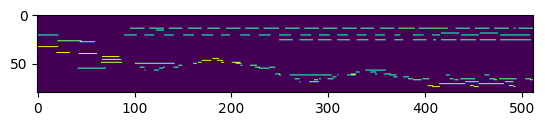

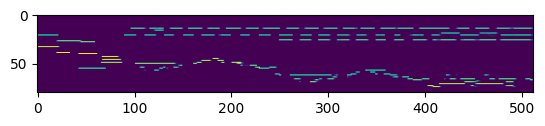

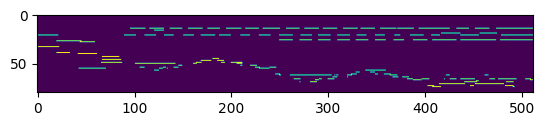

torch.Size([128, 512])
(512, 128)


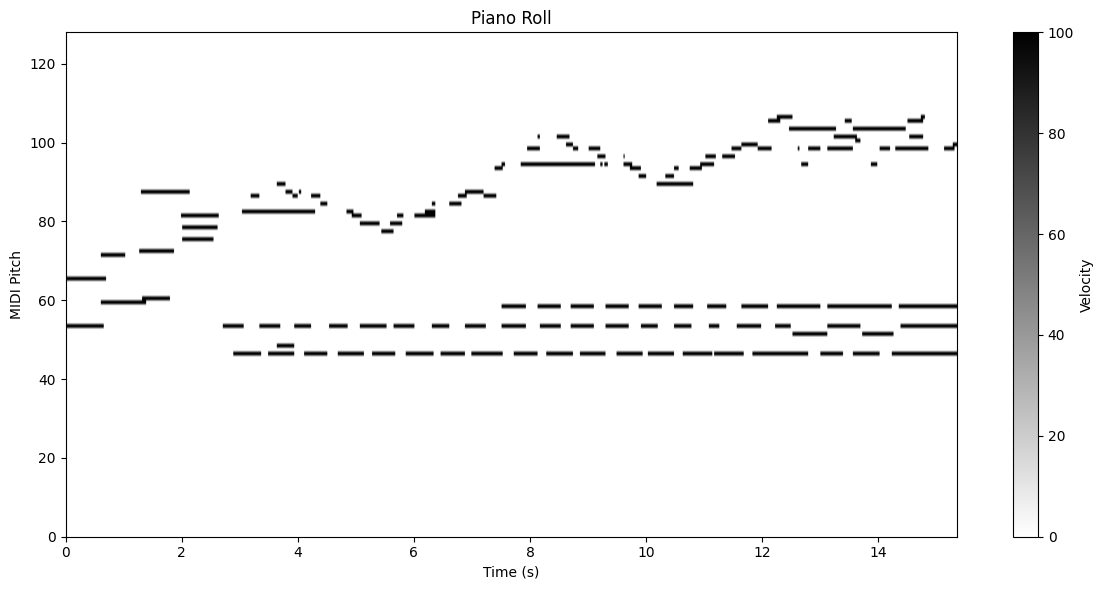

In [14]:
model.eval()
sample_input = next(iter(train_loader)).float()
sample_input[sample_input > 0] = 1
sample_input = sample_input.to(model.device)

with torch.no_grad():
    _, reconstructed_output, _, indicies = model(sample_input)

print(indicies.shape)
reconstructed_output = torch.sigmoid(reconstructed_output)
plt.imshow(sample_input[0, 0].cpu().numpy())
plt.show()
plt.imshow(reconstructed_output[0, 0].cpu().numpy())
plt.show()
tresh = 0.25
reconstructed_output[reconstructed_output > tresh] = 1
reconstructed_output[reconstructed_output <= tresh] = 0
plt.imshow(reconstructed_output[0, 0].cpu().numpy())
plt.show()

tolisten = reconstructed_output
tolisten = tolisten.squeeze(1)
_sample = to_128(tolisten[0].cpu())
print(_sample.shape)
midi = multi_hot_to_midi(_sample.cpu().numpy().T)
plot_midi_pianoroll(midi)
from IPython.display import Audio
midi.write('bachfromergen.mid')
midi_to_audio(midi)

# Sampling

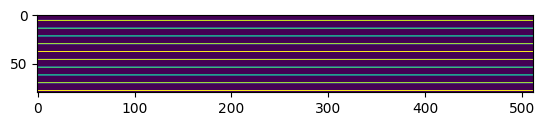

In [15]:
with torch.no_grad():
    reconstructed_output = model.vqvae.decode_from_latent_indices(torch.randint(0, 128, size=(1, 10, 64), device=model.device)*0 + 43)

reconstructed_output[reconstructed_output > tresh] = 1
reconstructed_output[reconstructed_output <= tresh] = 0
plt.imshow(reconstructed_output[0, 0].cpu().numpy())
plt.show()

torch.Size([128, 512])
(512, 128)


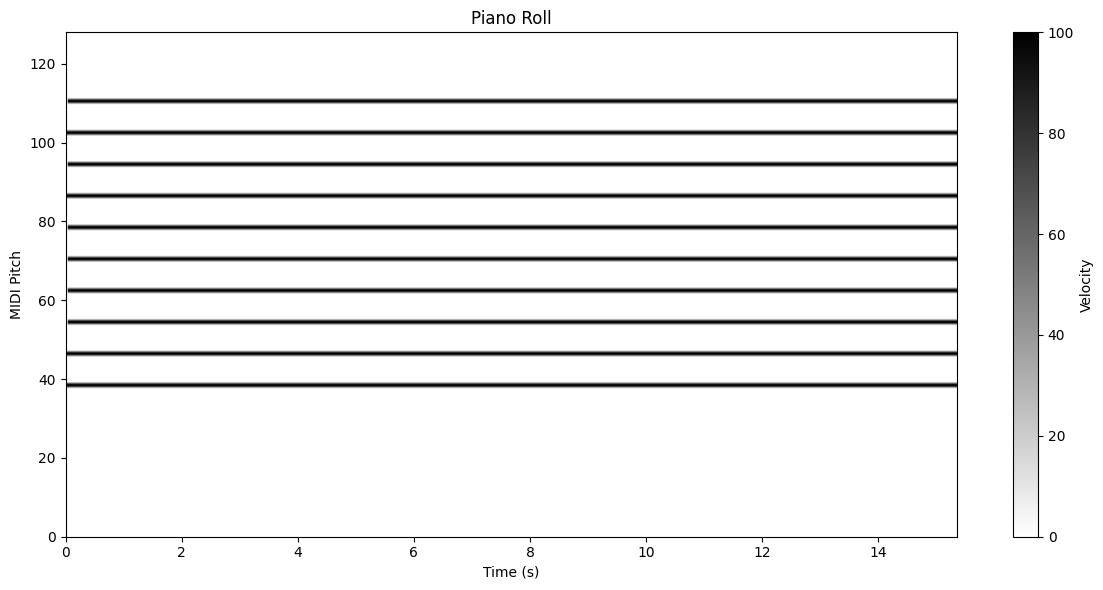

In [16]:
tolisten = reconstructed_output
tolisten = tolisten.squeeze(1)
_sample = to_128(tolisten[0].cpu())
print(_sample.shape)
midi = multi_hot_to_midi(_sample.cpu().numpy().T)
plot_midi_pianoroll(midi)
from IPython.display import Audio
midi.write('bachfromergen.mid')
midi_to_audio(midi)

In [21]:
torch.save(model, "VqMidi_Maestro1.pt", weights_only=False)

TypeError: save() got an unexpected keyword argument 'weights_only'